# Pre-Processing and Analysis
* Version 1: Create Patches from Images
* Version 2: Create Patches from Masks
* Version 3: Check if the marking distribution aligns with the Gleason Score given

### Steps to create sliding window images slices with Pytorch
Sliding window is the standard approach used to process WSI, so that the input files can be accomodated in the GPU. The whole image is broken into tiles of regular size and then fed into classification or segmentation algorithms

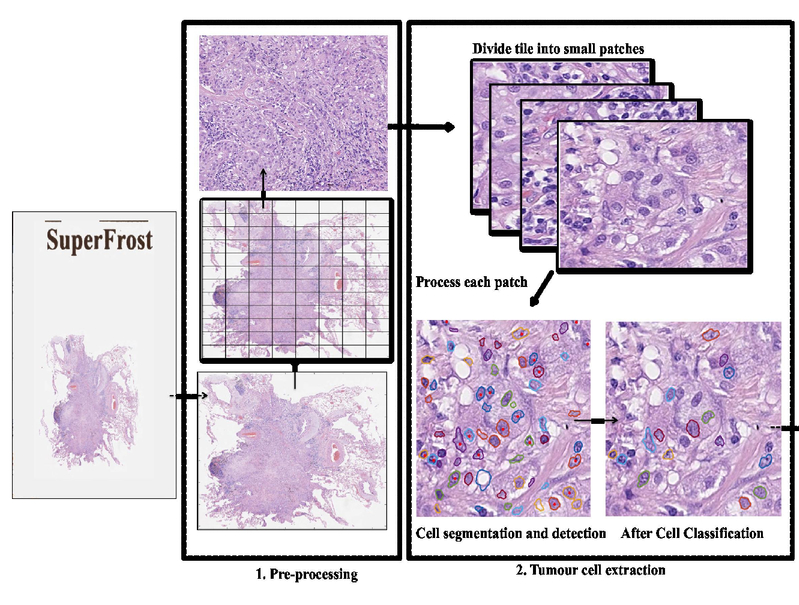

In [ ]:
#Usual Imports
import skimage.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
import cv2
import torch
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [ ]:
#Check input file
!ls ../input/prostate-cancer-grade-assessment/train_images/008069b542b0439ed69b194674051964.tiff

In [ ]:
#Load input file and check dimensions
file_path = f'../input/prostate-cancer-grade-assessment/train_images/008069b542b0439ed69b194674051964.tiff'
image = skimage.io.MultiImage(file_path)
image = cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB)
image.shape

In [ ]:
#Display the file
plt.imshow(image)

In [ ]:
#Convert to torch and CHW format
input = torch.from_numpy(image)
input.transpose_(0, 2).shape

In [ ]:
# Create patches of size 512x512
patch_size = 512
stride=patch_size

patches = input.data.unfold(0, 3, 3).unfold(1, patch_size, stride).unfold(2, patch_size, stride)
patches.shape

In [ ]:
def plot_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()
    
def showTensor(aTensor):
    plt.figure()
    plt.imshow(aTensor.numpy())
    plt.colorbar()
    plt.show()

In [ ]:
#Load mask file
mask_path = f'../input/prostate-cancer-grade-assessment/train_label_masks/008069b542b0439ed69b194674051964_mask.tiff'
mask = skimage.io.MultiImage(mask_path)
mask = cv2.cvtColor(mask[0], cv2.COLOR_BGR2RGB)
mask.shape

In [ ]:
#Only the third channel has the markings
np.unique(mask[:,:,2])

In [ ]:
#Convert to torch and CHW format
input_mask = torch.from_numpy(mask)
input_mask.transpose_(0, 2).shape

In [ ]:
mask_patches = input_mask.data.unfold(0, 3, 3).unfold(1, patch_size, stride).unfold(2, patch_size, stride)
mask_patches.shape

In [ ]:
#Show a Random Patch
plot_image(patches[0][40][3])
showTensor(mask_patches[0][40][3][-1]);

## Get the percentage Distribution from Masks and cross check with Gleason Score

In [ ]:
train=pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
check_score = train.loc[train['data_provider'] == 'radboud',['image_id','gleason_score']]

In [ ]:
check_score=check_score.head(5)

The value '0' in the mask corresponds to background and unknown areas, let us avoid those and check the percentage distribution of other labels and see if it matches with the Gleason Score.

We are considering the markings made under 'radboud' category as its straight forward to derive the Gleason score based on the markings which range from 0 to 5.

In [ ]:
output=list()
for index, row in tqdm(check_score.iterrows()):
    filename = row.image_id
    gleason_score = row.gleason_score
    mask_path = Path('../input/prostate-cancer-grade-assessment/train_label_masks/'+filename+'_mask.tiff')
    mask = skimage.io.MultiImage(str(mask_path))
    mask = cv2.cvtColor(mask[0], cv2.COLOR_BGR2RGB)
    input_mask = torch.from_numpy(mask)
    input_mask.transpose_(0, 2)

    a,b = torch.unique(input_mask, return_counts=True)
    a,b = a.numpy(),b.numpy()
    i = 0 if a[0]!=0 else 1    
    c = b[i:]/np.sum(b[i:])*100

    #dict(zip(a[1:], c))
    final = [filename,[(k,v) for k,v in dict(zip(a[1:], c)).items()],gleason_score]
    del mask_path,mask,input_mask, a,b,i,c 
    output = output+final
    

In [ ]:
output

Based on the label distribution in the masks, it appears files '*004dd32d9cd167d9cc31c13b704498af*' and '*0068d4c7529e34fd4c9da863ce01a161*' are incorrectly labelled.

There is are no markings of "cancerous epithelium (Gleason 3)" but score is given as '3+3' in first case.
In the second "cancerous epithelium (Gleason 3)" is only 0.005% and no marking for "cancerous epithelium (Gleason 4)"

More checking might be needed to evaluate all the 5160 files marked in radboud.